In [37]:
import pandas as pd
import numpy as np
import simulate
import matplotlib.pyplot as plt
import calculate_return as cr
import datetime as dt
import seaborn as sns

#### Import data and prepare returns

In [38]:
df = pd.read_csv('shiller_data.txt', sep="\t", index_col=0, parse_dates=True)
df.index = pd.to_datetime(df.index.date)
df['sp_return'] = (df['sp']+df['dividend']).pct_change()

### Loop over every 50 year period starting from january 1871 and calculate returns

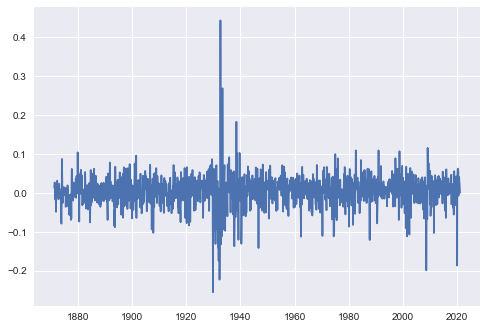

In [39]:
plt.plot(df['sp_return'])
#plt.yscale('log')

In [6]:
final_wealth = []

#for year in range(1871, 1899):
for year in range(1871, 1971):
    for month in range(1, 13):
        begin = dt.date(year, month, 1).strftime('%Y-%m-%d')
        end = dt.date(year+50, month, 1).strftime('%Y-%m-%d')
        returns = df.copy().loc[begin:end, 'sp_return'].values
        #cpi = df.loc[begin:end, 'cpi']*100/df.loc[begin, 'cpi']
        rf = df.copy().loc[begin:end, 'long_rf'].values/100
        rm = rf.copy() + 0.02
        shiller_return = cr.fetch_returns_shiller(returns=returns, YEARLY_RF=rf, YEARLY_RM=rm, YEARLY_INCOME_GROWTH=0.03)
        final_wealth.extend([shiller_return.loc[600, ['dual_phase', 'single_phase', '100', '9050']].values])
        #assert((returns == df.loc[begin:end, 'sp_return'].values).all)

[0.00611864 0.00611864 0.00612703 0.00612703 0.00612703 0.00613541
 0.00613541 0.00613541 0.0061438  0.0061438  0.0061438  0.00615218
 0.00615218 0.00616895 0.00618572 0.00620249 0.00621087 0.00622764
 0.00624442 0.00626119 0.00627796 0.00629473 0.00630311 0.00631989
 0.00633666 0.00632827 0.00631989 0.0063115  0.00630311 0.00629473
 0.00629473 0.00628634 0.00627796 0.00626957 0.00626119 0.0062528
 0.00624442 0.00621926 0.00618572 0.00616057 0.00613541 0.00610187
 0.00607672 0.00605157 0.00601804 0.00599289 0.00596774 0.0059342
 0.00590906 0.00587553 0.005842   0.00580847 0.00577494 0.00574142
 0.00570789 0.00567437 0.00564085 0.00560733 0.00557381 0.00554029
 0.00550677 0.00549839 0.00549002 0.00548164 0.00546488 0.0054565
 0.00544812 0.00543974 0.00543136 0.00542298 0.00540623 0.00539785
 0.00538947 0.00538109 0.00537271 0.00536434 0.00535596 0.00534758
 0.00534758 0.0053392  0.00533083 0.00532245 0.00531407 0.00530569
 0.00529731 0.00528894 0.00528056 0.00527218 0.00526381 0.0052554

KeyboardInterrupt: 

In [124]:
shiller_results = pd.DataFrame(final_wealth, columns=['dual_phase', 'single_phase', '100', '9050'],
                              index = pd.date_range('1921-01-01', '2020-12-01', freq='MS'))

Text(0.5, 0, 'Year')

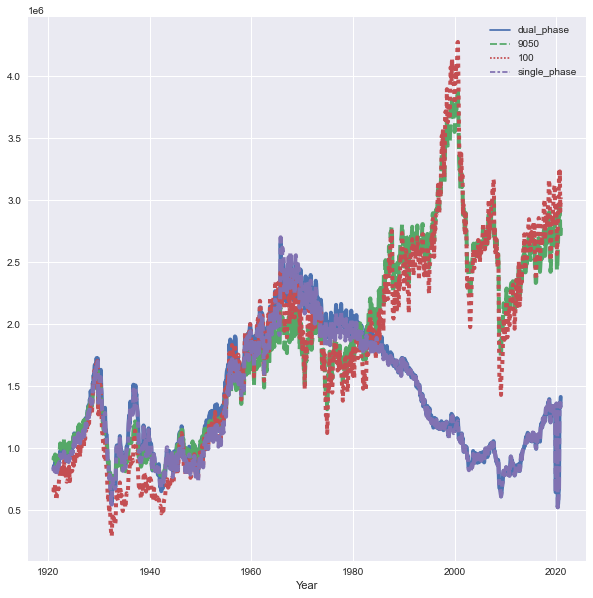

In [126]:
plt.style.use('seaborn')
fig, ax = plt.subplots(1, 1, figsize=(10, 10))
sns.lineplot(data = shiller_results.loc[:,['dual_phase', '9050', '100', 'single_phase']], linewidth = 4, linestyle="solid")      # Levered investments
ax.set_xlabel('Year')


## Pi development

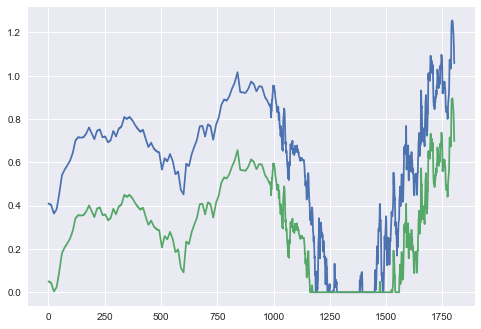

In [40]:
rf = df.loc[:, 'long_rf'].values/100
rm = rf +0.02
plt.plot(cr.calc_pi(2, 0.0278, 0.076, rf))
plt.plot(cr.calc_pi(2, 0.0278, 0.076, rm))

### 30-year pi development

In [41]:
import pandas as pd
import numpy as np
import simulate
import matplotlib.pyplot as plt
import calculate_return as cr
import datetime as dt
import seaborn as sns

In [44]:
roll_df = df.rolling(12*30).mean().dropna()
roll_std = (df['sp_return']).rolling(12*30).std().dropna()
roll_sp_return = np.exp(roll_df['sp_return']*12)-1
roll_rf = roll_df['long_rf']/100
roll_rm = roll_rf.copy()+0.02

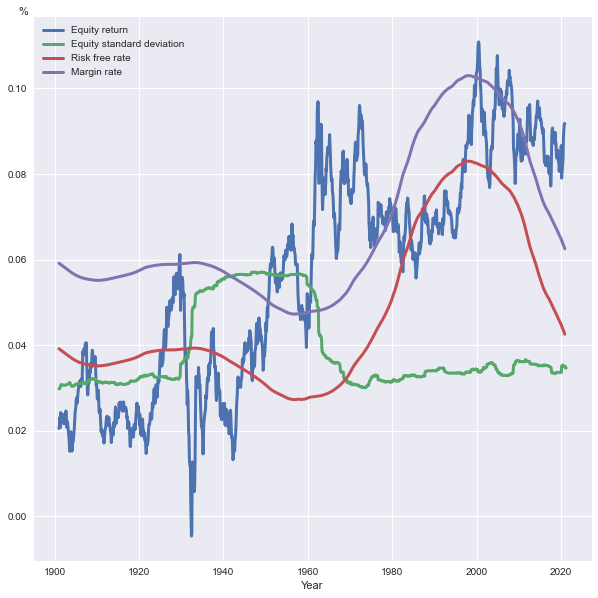

In [62]:
fig, ax = plt.subplots(1, 1, figsize=(10, 10))
ax.plot(roll_sp_return, linewidth = 3)
ax.plot(roll_std, linewidth = 3)
ax.plot(roll_rf, linewidth = 3)
ax.plot(roll_rm, linewidth = 3)
ax.legend(['Equity return', 'Equity standard deviation', 'Risk free rate', 'Margin rate'])
ax.set_xlabel('Year')
ax.set_ylabel('%', rotation=0, loc='top', labelpad=-21)
fig.savefig('Empirical/rolling_development.png')

### Resulting pi

In [ ]:
combined = zip(roll_rf, roll_sp_return, roll_std)

pi_rf = [cr.pi_arr(rf, 2, std, ret, 0) for rf, ret, std in combined]
plt.plot(pi_rf)
#pi_rf = pd.DataFrame(pi_rf, index = roll_rf.index)

### Using new 30 year method to test strategy

In [50]:
final_wealth = []

#for year in range(1871, 1899):
for year in range(1901, 1971):
    for month in range(1, 13):
        begin = dt.date(year, month, 1).strftime('%Y-%m-%d')
        end = dt.date(year+50, month, 1).strftime('%Y-%m-%d')
        returns = df.copy().loc[begin:end, 'sp_return'].values
        #cpi = df.loc[begin:end, 'cpi']*100/df.loc[begin, 'cpi']
        rf = roll_rf.copy().loc[begin]
        std = roll_std.copy().loc[begin]
        mr = roll_sp_return.copy().loc[begin]
        YEARLY_RF = np.full(len(returns), rf)
        YEARLY_RM = YEARLY_RF + 0.02

        pi_rf_shiller = cr.calc_pi(2, std, mr, YEARLY_RF)
        pi_rm_shiller = cr.calc_pi(2, std, mr, YEARLY_RF)
        
        shiller_return = cr.fetch_returns_shiller(returns=returns, YEARLY_RF=roll_rf.copy().loc[begin:end], YEARLY_RM=roll_rf.copy().loc[begin]+0.02, YEARLY_INCOME_GROWTH=0.03, 
                                                 MR = roll_sp_return.loc[begin], PI_RF = pi_rf_shiller, PI_RM = pi_rm_shiller)
        final_wealth.extend([shiller_return.loc[600, ['dual_phase', 'single_phase', '100', '9050']].values])
        #assert((returns == df.loc[begin:end, 'sp_return'].values).all)

In [51]:
shiller_results = pd.DataFrame(final_wealth, columns=['dual_phase', 'single_phase', '100', '9050'],
                              index = pd.date_range('1951-01-01', '2020-12-01', freq='MS'))

Text(0.5, 0, 'Year')

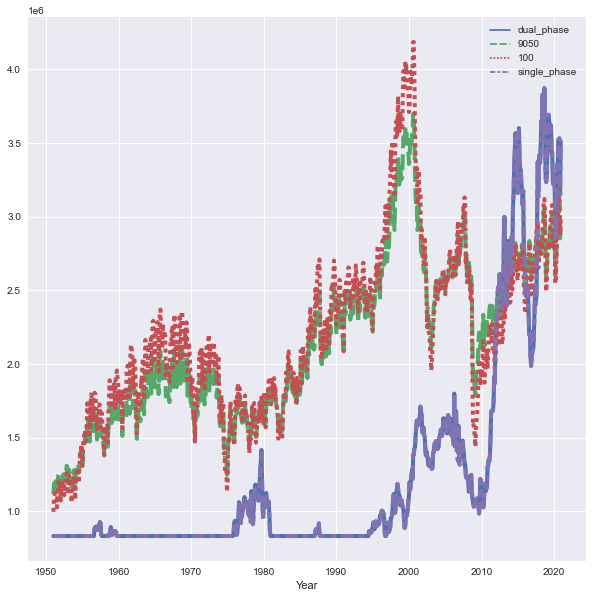

In [52]:
plt.style.use('seaborn')
fig, ax = plt.subplots(1, 1, figsize=(10, 10))
sns.lineplot(data = shiller_results.loc[:,['dual_phase', '9050', '100', 'single_phase']], linewidth = 4, linestyle="solid")      # Levered investments
ax.set_xlabel('Year')


## Looking at indivdual returns

In [171]:
all_returns = []
cnt = 0
#for year in range(1871, 1875):
for year in range(1871, 1971):
    for month in range(1, 13):
        begin = dt.date(year, month, 1).strftime('%Y-%m-%d')
        end = dt.date(year+50, month, 1).strftime('%Y-%m-%d')
        returns = df.copy().loc[begin:end, 'sp_return'].values
        #cpi = df.copy().loc[begin:end, 'cpi']*100/df.loc[begin, 'cpi']
        rf = df.copy().loc[begin:end, 'long_rf'].values/100
        rm = rf.copy() + 0.02
        shiller_return = cr.fetch_returns_shiller(returns=returns, YEARLY_RF=rf, YEARLY_RM=rm, YEARLY_INCOME_GROWTH=0.03)
        shiller_return.index = pd.date_range(begin, end, freq='MS')
        shiller_return['cnt'] = cnt
        all_returns.extend([shiller_return.loc[:, ['cnt', 'dual_phase', 'single_phase', '100', '9050']]])
        cnt += 1

In [172]:
test = pd.concat(all_returns)

In [173]:
test

,cnt,dual_phase,single_phase,100,9050
1871-01-01,0,4.500000e+02,4.500000e+02,450.0,450.0
1871-02-01,0,9.303574e+02,9.303574e+02,919.0,918.0
1871-03-01,0,1.460242e+03,1.460242e+03,1419.0,1414.0
1871-04-01,0,2.036518e+03,2.036518e+03,1945.0,1936.0
1871-05-01,0,2.636579e+03,2.636579e+03,2487.0,2472.0
...,...,...,...,...,...
2020-08-01,1199,1.446876e+06,1.447182e+06,2928628.0,2702309.0
2020-09-01,1199,1.434806e+06,1.435108e+06,2907036.0,2686654.0
2020-10-01,1199,1.462923e+06,1.463231e+06,2954031.0,2722482.0
2020-11-01,1199,1.529178e+06,1.529500e+06,3067699.0,2808328.0


In [174]:
all_return_df = test.reset_index().melt(id_vars=['index', 'cnt'], ignore_index=True)

In [175]:
all_return_df

,index,cnt,variable,value
0,1871-01-01,0,dual_phase,4.500000e+02
1,1871-02-01,0,dual_phase,9.303574e+02
2,1871-03-01,0,dual_phase,1.460242e+03
3,1871-04-01,0,dual_phase,2.036518e+03
4,1871-05-01,0,dual_phase,2.636579e+03
...,...,...,...,...
2884795,2020-08-01,1199,9050,2.702309e+06
2884796,2020-09-01,1199,9050,2.686654e+06
2884797,2020-10-01,1199,9050,2.722482e+06
2884798,2020-11-01,1199,9050,2.808328e+06


<AxesSubplot:xlabel='index', ylabel='value'>

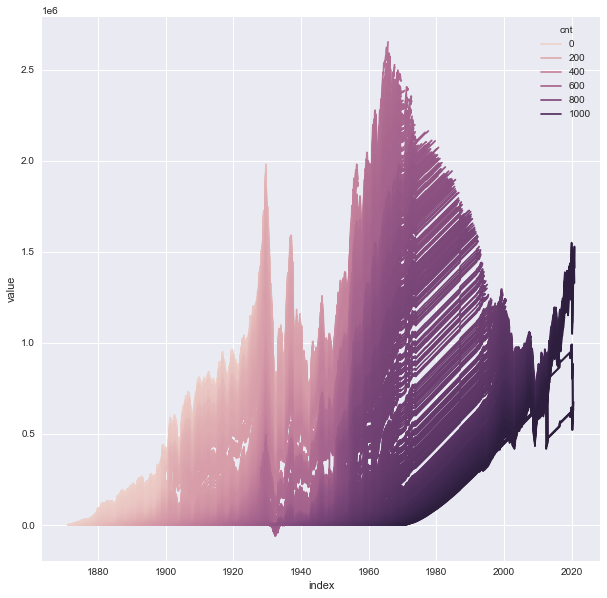

In [176]:
a = .3
s = .1
fig, ax = plt.subplots(1, 1, figsize=(10, 10))
sns.lineplot(data = all_return_df[all_return_df['variable'] == 'dual_phase'], y='value', x='index', hue='cnt') 
#plt.scatter(x = test.index, y=test['dual_phase'], alpha=a, s=s)
#plt.scatter(x = test.index, y=test['9050'], alpha=a, s=s)
#plt.scatter(x = test.index, y=test['100'], alpha=a, s=s)
#plt.scatter(x = test.index, y=test['single_phase'], alpha=a, s=s)

In [139]:
test.reset_index().melt(id_vars='index')

,index,variable,value
0,1871-01-01,dual_phase,4.500000e+02
1,1871-02-01,dual_phase,9.303574e+02
2,1871-03-01,dual_phase,1.460242e+03
3,1871-04-01,dual_phase,2.036518e+03
4,1871-05-01,dual_phase,2.636579e+03
...,...,...,...
2884795,2020-08-01,9050,2.702309e+06
2884796,2020-09-01,9050,2.686654e+06
2884797,2020-10-01,9050,2.722482e+06
2884798,2020-11-01,9050,2.808328e+06
